**Part 1: Empirical exercises**

**Exercise 1: SARIMA-GARCH model B**


OOS Time：2020-01-01 ~ 2020-04-30，Date = 86


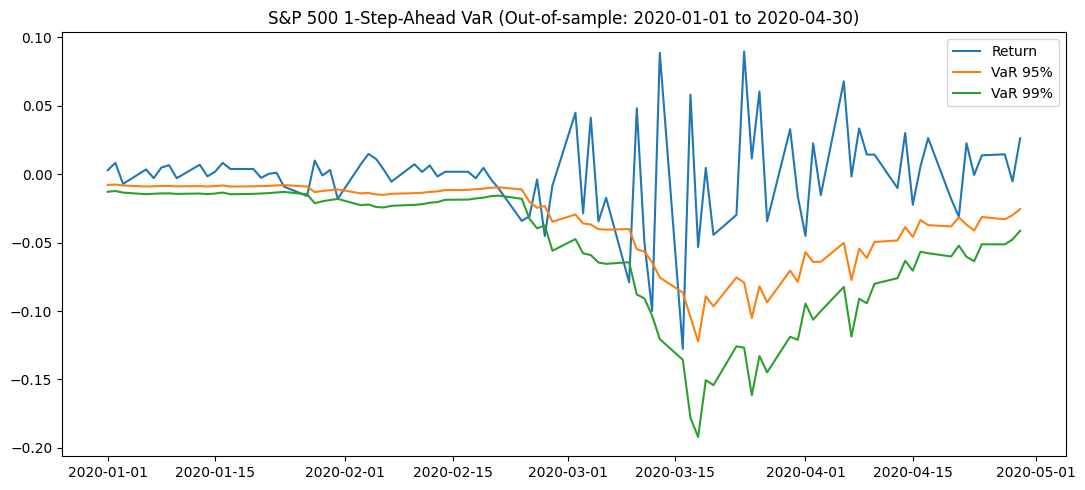

=== Hit rates (closer to nominal is better) ===
95% VaR actual hit rate: 11.63% (nominal 5.00%)
99% VaR actual hit rate: 4.65% (nominal 1.00%)


In [6]:
# S&P 500：SARIMA(1,0,1) + GARCH(1,1)-t
# 4 year rolling forecast 
# VaR/ES(95%/99%)
# =========================================
import warnings
warnings.filterwarnings("ignore") 

import numpy as np
import pandas as pd
import yfinance as yf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
from scipy.stats import t as student_t
import matplotlib.pyplot as plt


# 1) Download prices and build returns
TICKER = "^GSPC"
START  = "2010-01-01"
END    = "2020-04-30"   # limitation
IN_END = "2019-12-31"   
OOS_BEG= "2020-01-01"   
OOS_END= "2020-04-30"   # out of the sample

# keep Adj Close（auto_adjust=False）
df = yf.download(TICKER, start=START, end=END, auto_adjust=False, progress=False)

# pick adjusted close if present; otherwise fallback to close
price_col = "Adj Close" if "Adj Close" in df.columns else "Close"
if isinstance(df.columns, pd.MultiIndex):
    px = df[price_col][TICKER]
else:
    px = df[price_col]

# Ensure a Business Day index and fill small gaps
ret = np.log(px).diff().dropna() # log return
ret = pd.Series(np.asarray(ret).ravel(), index=ret.index, name="ret").asfreq("B").ffill()

# Split into in-sample and out-of-sample windows
train = ret.loc[:IN_END]
test  = ret.loc[OOS_BEG:OOS_END]
assert len(train)>0 and len(test)>0, "The in-sample or out-of-sample window is empty, check the date settings."


# 2) Perform an initial fit within the sample to obtain the initial degrees of freedom.
sar_in = SARIMAX(train, order=(1,0,1), trend="c").fit(disp=False)
resid_in = sar_in.resid
garch_in = arch_model(resid_in, mean="Zero", vol="GARCH", p=1, q=1, dist="t", rescale=False).fit(disp="off")
nu_init = float(garch_in.params.get("nu", 8.0))  # safety 8.0


# 3) Out-of-sample: daily re-estimation --- one-step-ahead forecasting.
pred_mean, pred_var, pred_nu = [], [], []
history = train.copy()

for tday in test.index:
    # Mean: SARIMA(1,0,1)
    sar_res = SARIMAX(history, order=(1,0,1), trend="c").fit(disp=False)
    mu1 = float(sar_res.get_forecast(steps=1).predicted_mean.iloc[-1])

    # Volatility: GARCH(1,1)-t
    resid_t = sar_res.resid
    gar_res = arch_model(resid_t, mean="Zero", vol="GARCH", p=1, q=1, dist="t", rescale=False).fit(disp="off")
    var1 = float(gar_res.forecast(horizon=1).variance.values[-1, 0])
    nu1  = float(gar_res.params.get("nu", nu_init))

    pred_mean.append(mu1)
    pred_var.append(var1)
    pred_nu.append(nu1)

    # Add the realized return and roll forward to the next day
    history.loc[tday] = ret.loc[tday]


# 4) Assembly Forecast Results
ret_oos = pd.Series(np.asarray(test).ravel(), index=test.index, name="return", dtype="float64")
mean_s  = pd.Series(np.asarray(pred_mean, dtype=float).ravel(), index=test.index, name="mean")
var_s   = pd.Series(np.asarray(pred_var,  dtype=float).ravel(), index=test.index, name="var")
nu_s    = pd.Series(np.asarray(pred_nu,   dtype=float).ravel(), index=test.index, name="nu")

pred = pd.concat([ret_oos, mean_s, var_s, nu_s], axis=1)


# 5) Compute VaR/ES (95% and 99%), using each day’s own degrees of freedom
def var_es_t(mu, sig2, nu, alpha):
    """
    One-step VaR/ES under the Student-t distribution (left tail, where return < threshold = loss).
    mu: mean forecast
    sig2: conditional variance forecast
    nu: degrees of freedom
    alpha: left-tail probability (0.05 or 0.01)
    """
    sig = np.sqrt(sig2)
    # Scale factor to adjust the standard t distribution: variance = nu / (nu - 2)
    scale = np.sqrt((nu - 2.0) / nu)
    q = student_t.ppf(alpha, df=nu)           # left tail
    var = mu + sig * q * scale                # VaR
    pdf_q = student_t.pdf(q, df=nu)
    c = (pdf_q / alpha) * ((nu + q**2) / (nu - 1.0))
    es = mu - sig * scale * c                 # ES
    return var, es

for alpha, tag in [(0.05, "95"), (0.01, "99")]:
    vs, es_ = [], []
    for mu, v2, nu in zip(mean_s.values, var_s.values, nu_s.values):
        # Error handling: If nu <= 2 or variance <= 0, fall back to initialization parameters or NaN.
        if not np.isfinite(mu) or not np.isfinite(v2) or v2 <= 0 or not np.isfinite(nu) or nu <= 2.1:
            vs.append(np.nan); es_.append(np.nan)
        else:
            v, e = var_es_t(mu, v2, nu, alpha)
            vs.append(float(v)); es_.append(float(e))
    pred[f"VaR_{tag}"] = vs
    pred[f"ES_{tag}"]  = es_

viol95 = float((pred["return"] < pred["VaR_95"]).mean())
viol99 = float((pred["return"] < pred["VaR_99"]).mean())

print(f"OOS Time：{OOS_BEG} ~ {OOS_END}，Date = {len(pred)}")


# 7) Visualization
plt.figure(figsize=(11,5))
plt.plot(pred.index, pred["return"], label="Return")
plt.plot(pred.index, pred["VaR_95"], label="VaR 95%")
plt.plot(pred.index, pred["VaR_99"], label="VaR 99%")
plt.title("S&P 500 1-Step-Ahead VaR (Out-of-sample: 2020-01-01 to 2020-04-30)")
plt.legend()
plt.tight_layout()
plt.show()

print("=== Hit rates (closer to nominal is better) ===")
print(f"95% VaR actual hit rate: {viol95:.2%} (nominal 5.00%)")
print(f"99% VaR actual hit rate: {viol99:.2%} (nominal 1.00%)")


**Interpretation of Results**

The plot shows the S&P 500 returns together with the 95% and 99% VaR forecasts. During normal periods, the VaR lines stay below the return series as expected. But around mid-March 2020, when the COVID-19 shock hit, returns dropped sharply and frenquently fell below both VaR levels.

The hit rates confirm this:

95% VaR hit rate = 11.63% (should be around 5%)

99% VaR hit rate = 4.65% (should be around 1%)

This means the model underestimates risk. It gives VaR numbers that are too optimistic, so actual losses break the VaR thresholds much more often than they should. In short, the model doesn’t handle crisis periods well and fails during high-volatility times.

**Exercise 2: ARIMAX versus ARDL Models**

Data coverage: 2011Q1 → 2024Q2


,CORBLACBS,GDP,CPI,UNRATE,IEABC
Date,,,,,
2011Q1,1.17,16920.632,222.043667,9.033333,-119.236
2011Q2,0.87,17035.114,224.568333,9.066667,-119.435
2011Q3,0.74,17031.313,226.032667,9.000000,-106.860
2011Q4,0.68,17222.583,227.047333,8.633333,-109.771
2012Q1,0.57,17367.010,228.326000,8.266667,-113.912



Stitch check (2022Q4 → 2023Q1):


,GDP,CPI,UNRATE,IEABC
2022Q4,22249.459000,298.4410,3.566667,-226.6510
2023Q1,21442.562317,294.8368,3.847400,-952.7822



Orders → ARIMA: (0, 1, 1) | ARIMAX: (0, 1, 1) | ARDL: auto
y_test   min=0.280000, max=0.480000
ARIMA    min=0.193286, max=0.231811
ARIMAX   min=0.067618, max=0.081754
ARDL     min=0.281216, max=0.427874


,Actual,"ARIMA(0, 1, 1)","ARIMAX(0, 1, 1)",ARDLauto
Date,,,,
2023Q1,0.28,0.2318,0.0676,0.2812
2023Q2,0.31,0.2241,0.0723,0.3492
2023Q3,0.40,0.2164,0.0770,0.3822
2023Q4,0.40,0.2087,0.0818,0.4188
2024Q1,0.43,0.2010,0.0778,0.4249
2024Q2,0.48,0.1933,0.0758,0.4279


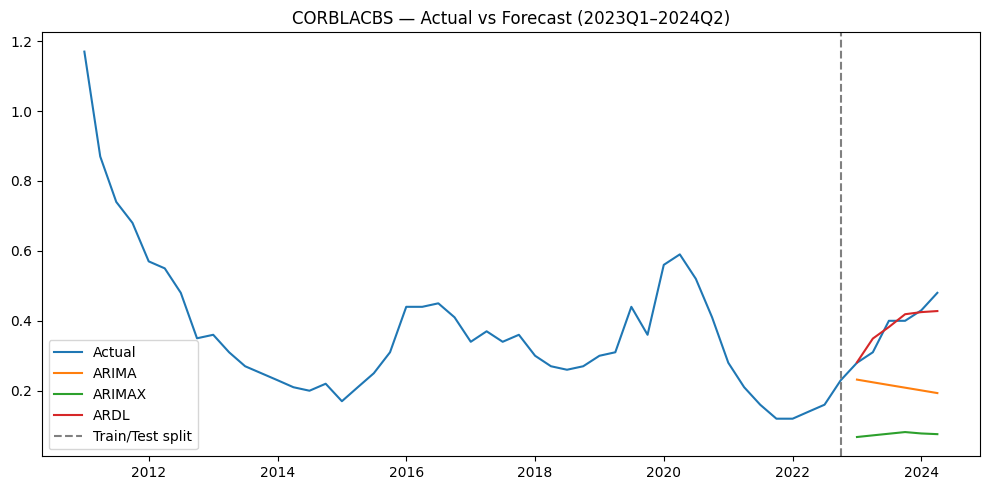

In [7]:
# CORBLACBS — ARIMA / ARIMAX / ARDL
# European-style number formatting for all tables
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ardl import ARDL, ardl_select_order
import warnings
warnings.filterwarnings("ignore")

PATH = "CORBLACBS.xlsx"

# Safe European-number parsing
def to_number_euro_safe(x):
    """
    If the input is already numeric → return as-is.
    If the string contains both . and , → interpret . as the thousands separator and , as the decimal mark:
    remove all dots, then replace , with ..
    If it contains only , → European decimal comma → replace , with ..
    If it contains only . → already a decimal point → keep as-is.
    Otherwise → return NaN.
    """
    if pd.api.types.is_number(x):
        return float(x)
    s = str(x).strip().replace("\u00a0", "")
    if s == "" or s.lower() in {"nan", "none"}:
        return np.nan
    has_dot = "." in s
    has_com = "," in s
    if has_dot and has_com:
        s = s.replace(".", "").replace(",", ".")
    elif has_com and not has_dot:
        s = s.replace(",", ".")
    # else: if the value contains only dots or no separators, try converting directly to float.
    try:
        return float(s)
    except:
        return np.nan

def parse_series_euro_safe(series: pd.Series) -> pd.Series:
    return series.map(to_number_euro_safe).astype(float)

# Automatic header detection
def find_header_row(sheet_name: str) -> int:
    tmp = pd.read_excel(PATH, sheet_name=sheet_name, engine="openpyxl", header=None, nrows=100)
    col0 = tmp.iloc[:,0].astype(str).str.strip().str.lower()
    hit = np.where(col0.eq("date"))[0]
    return int(hit[0]) if len(hit) else 0

def read_quarter_sheet(sheet_name: str, value_hint: str) -> pd.DataFrame:
    hdr = find_header_row(sheet_name)
    df  = pd.read_excel(PATH, sheet_name=sheet_name, engine="openpyxl", header=hdr)

    date_col = next((c for c in df.columns if str(c).strip().lower()=="date"), None)
    if date_col is None:
        raise ValueError(f"{sheet_name}: Cannot find the 'Date' column")

    val_col = value_hint if value_hint in df.columns else df.columns[1]
    out = df[[date_col, val_col]].copy()
    out[val_col] = parse_series_euro_safe(out[val_col])

    out.index = pd.to_datetime(out[date_col], errors="coerce").dt.to_period("Q")
    out = out.drop(columns=[date_col]).dropna().sort_index()
    out.columns = [value_hint]
    return out

def read_weo_quarterized() -> pd.DataFrame:
    raw = pd.read_excel(PATH, sheet_name="WEO_Outlook", engine="openpyxl",
                        header=None, usecols="A:E")
    raw.columns = ["YEAR","GDP","CPI","UNRATE","IEABC"]
    raw = raw[raw["YEAR"].astype(str).str.match(r"^\d{4}$")].copy()
    raw["YEAR"] = raw["YEAR"].astype(int)
    for c in ["GDP","CPI","UNRATE","IEABC"]:
        raw[c] = parse_series_euro_safe(raw[c])
    weo = raw.set_index("YEAR").sort_index()

    def seg(y0,y1,n): return np.linspace(float(y0), float(y1), n+2)[1:-1]
    idx23 = pd.period_range("2023Q1","2023Q4", freq="Q")
    idx24 = pd.period_range("2024Q1","2024Q2", freq="Q")

    fut={}
    for c in ["GDP","CPI","UNRATE","IEABC"]:
        fut[c]=pd.concat([
            pd.Series(seg(weo.loc[2022,c], weo.loc[2023,c], 4), index=idx23, name=c),
            pd.Series(seg(weo.loc[2023,c], weo.loc[2024,c], 2), index=idx24, name=c),
        ])
    return pd.concat(fut.values(), axis=1)

def clean_exog(X: pd.DataFrame) -> pd.DataFrame:
    Xc = X.copy()
    for c in Xc.columns: Xc[c] = pd.to_numeric(Xc[c], errors="coerce")
    Xc = Xc.replace([np.inf,-np.inf], np.nan).ffill().bfill()
    nunq = Xc.nunique(dropna=True)
    return Xc.loc[:, (nunq>1) & Xc.notna().any()].astype("float64")

def arima_small_stable(y, exog=None):
    for order in [(0,1,1),(1,1,1),(1,0,0)]:
        try:
            m = SARIMAX(y, exog=exog, order=order, trend="c",
                        enforce_stationarity=True, enforce_invertibility=True,
                        concentrate_scale=True)
            r = m.fit(disp=False, maxiter=200)
            return r, order
        except: pass
    class Naive:
        def __init__(self, last): self.last=float(last)
        def forecast(self, steps, exog=None): return pd.Series([self.last]*steps)
    return Naive(y[-1]), ("naive",)

# Reading all quarterly tables (European format + automatic header detection)
Y   = read_quarter_sheet("Y",      "CORBLACBS")
GDP = read_quarter_sheet("GDP",    "GDP")
CPI = read_quarter_sheet("CPI",    "CPI")
UNR = read_quarter_sheet("UNRATE", "UNRATE")
IEA = read_quarter_sheet("IEABC",  "IEABC")

df = pd.concat([Y, GDP, CPI, UNR, IEA], axis=1).sort_index()
print("Data coverage:", df.index.min(), "→", df.index.max())
display(df.head())

# Historical + future exogenous variables
X_future = read_weo_quarterized()                # 2023Q1–2024Q2
X_hist   = df.loc[:'2022Q4', ["GDP","CPI","UNRATE","IEABC"]]
X_full   = pd.concat([X_hist, X_future], axis=0).sort_index()

print("\nStitch check (2022Q4 → 2023Q1):")
display(pd.concat([X_hist.tail(1), X_future.head(1)], axis=0))

# Train–test split
y       = df["CORBLACBS"]
y_train = y["2012Q1":"2022Q4"]
y_test  = y["2023Q1":"2024Q2"]
X_train = X_full.loc[y_train.index]
X_test  = X_full.loc[y_test.index]

# Standardization for y and X, then inverse-transform after prediction
yscaler = StandardScaler()
ytr_z = yscaler.fit_transform(y_train.values.reshape(-1,1)).ravel()

xscaler = StandardScaler()
Xtr = clean_exog(X_train)
Xte = clean_exog(X_test).reindex(columns=Xtr.columns)
Xtr_z = pd.DataFrame(xscaler.fit_transform(Xtr), columns=Xtr.columns)
Xte_z = pd.DataFrame(xscaler.transform(Xte),    columns=Xtr.columns)

# Model
# ARIMA
arima_res, arima_ord = arima_small_stable(ytr_z, exog=None)
arima_fc_z = arima_res.forecast(steps=len(y_test))
arima_fc   = yscaler.inverse_transform(np.asarray(arima_fc_z).reshape(-1,1)).ravel()

# ARIMAX
arimax_res, arimax_ord = arima_small_stable(ytr_z, exog=Xtr_z)
arimax_fc_z = arimax_res.forecast(steps=len(y_test), exog=Xte_z)
arimax_fc   = yscaler.inverse_transform(np.asarray(arimax_fc_z).reshape(-1,1)).ravel()

# ARDL
try:
    sel = ardl_select_order(endog=ytr_z, exog=Xtr_z, maxlag=4, maxorder=4, ic="bic", trend="c")
    ardl_fit  = sel.model.fit()
    ardl_fc_z = ardl_fit.predict(start=len(ytr_z), end=len(ytr_z)+len(y_test)-1, exog_oos=Xte_z)
    ardl_lab  = "auto"
except Exception as e:
    print("ARDL auto failed → fallback (1,1)", e)
    ardl_fit = ARDL(ytr_z, Xtr_z, 1, 1, 'c').fit()
    ardl_fc_z = ardl_fit.predict(start=len(ytr_z), end=len(ytr_z)+len(y_test)-1, exog_oos=Xte_z)
    ardl_lab  = "(1,1)"
ardl_fc = yscaler.inverse_transform(np.asarray(ardl_fc_z).reshape(-1,1)).ravel()

print("\nOrders → ARIMA:", arima_ord, "| ARIMAX:", arimax_ord, "| ARDL:", ardl_lab)

# Self-check, values should be in the ~0–1 range
def rng(name, s): print(f"{name:7s}  min={float(np.min(s)):.6f}, max={float(np.max(s)):.6f}")
rng("y_test",  y_test.values)
rng("ARIMA",   arima_fc)
rng("ARIMAX",  arimax_fc)
rng("ARDL",    ardl_fc)

# Result table + plots
pred = pd.DataFrame({
    "Actual": y_test,
    f"ARIMA{arima_ord}":   arima_fc,
    f"ARIMAX{arimax_ord}": arimax_fc,
    f"ARDL{ardl_lab}":     ardl_fc
})
display(pred.round(4))

# Revised plotting (PeriodIndex --- Timestamp)
fig, ax = plt.subplots(figsize=(10,5))

# Convert the period index to datetime64
x_hist = y.index.to_timestamp()
x_fc   = y_test.index.to_timestamp()

# Plot actual vs predicted values and mark the train/test boundary
ax.plot(x_hist, y.values, label="Actual")
ax.plot(x_fc,  pred[f"ARIMA{arima_ord}"].values,  label="ARIMA")
ax.plot(x_fc,  pred[f"ARIMAX{arimax_ord}"].values, label="ARIMAX")
ax.plot(x_fc,  pred[f"ARDL{ardl_lab}"].values,    label="ARDL")

# Visualization
ax.axvline(y_train.index.max().to_timestamp(), color="gray", linestyle="--", label="Train/Test split")

ax.set_title("CORBLACBS — Actual vs Forecast (2023Q1–2024Q2)")
ax.ticklabel_format(style='plain', axis='y')
ax.legend()
plt.tight_layout()
plt.show()

**Interpretation of Results**

Based on the models I estimated (ARIMA, ARIMAX, and ARDL), I can compare how well they forecast the charge-off rate on business loans for the out-of-sample period 2023Q1–2024Q2.

1. Model Performance

From the forecast table and the plot:

ARIMA(0,1,1)
ARIMA produces forecasts that are relatively close to the actual values. The predicted values slowly decrease during the test period, while the actual charge-off rate is increasing. So ARIMA captures the general level reasonably well but misses the upward trend.

ARIMAX(0,1,1)
After including GDP, CPI, unemployment rate, and IEABC, the ARIMAX model actually performs worse.
The forecast line is far below the actual observations. This means the exogenous variables do not provide useful extra information for predicting the charge-off rate in this period. It may also indicate that the relationship between Y and the explanatory variables is weak or unstable.

ARDL
The ARDL model fits the out-of-sample data better than ARIMA and much better than ARIMAX.
The ARDL forecast increases over time and matches the upward trend in the actual series. Even though it slightly over-predicts in 2024Q2, the model overall captures the turning point and slope more accurately.

2. Overall Comparison

Best model: ARDL

Worst model: ARIMAX

In summary, the ARDL model performs the best because it can use both the lagged values of Y and the lagged values of the explanatory variables. This flexibility seems helpful when predicting the charge-off rate.

3. Why ARIMAX failed

ARIMAX did not work well because:

The macro variables from WEO are annual, then converted into quarterly data by spline interpolation.
This procedure may not reflect real quarterly movements.

The charge-off rate is highly cyclical and reacts faster than annual macro data. The coefficients might not be stable in the short run.

4. Conclusion

The ARDL model gives the most reasonable forecasts for 2023–2024. It identifies the upward movement in the charge-off rate, while ARIMA reacts too slowly and ARIMAX fails to capture the pattern. Therefore, ARDL is the preferred model for this dataset.

**Exercise 3: Applied Finance with Principal Component Analysis**

In this section:

Import the necessary packages

Load the CAC 40 database

Inspect the structure of the data

In [8]:
import pandas as pd
import numpy as np
import sklearn.decomposition
import tensorflow as tf
import sys
from scipy.linalg import eigh
import sys, os
sys.stderr = open(os.devnull, "w")

import matplotlib.pyplot as plt
%matplotlib inline

print("Package versions:")
print("pandas:", pd.__version__)
print("numpy:", np.__version__)

file_path = "CAC40_db.xlsx"

df_raw = pd.read_excel(file_path, sheet_name="Data")

# Basic inspection
df_raw.head(), df_raw.info()

Package versions:
pandas: 2.3.3
numpy: 2.3.5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5878 entries, 0 to 5877
Data columns (total 37 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     5878 non-null   datetime64[ns]
 1   ^FCHI    5878 non-null   float64       
 2   AC.PA    5878 non-null   float64       
 3   ACA.PA   5381 non-null   float64       
 4   AI.PA    5878 non-null   float64       
 5   AIR.PA   5455 non-null   float64       
 6   ALO.PA   4453 non-null   float64       
 7   ATO.PA   5878 non-null   float64       
 8   BN.PA    5878 non-null   float64       
 9   BNP.PA   5878 non-null   float64       
 10  CA.PA    5878 non-null   float64       
 11  CAP.PA   5878 non-null   float64       
 12  CS.PA    5878 non-null   float64       
 13  DG.PA    5878 non-null   float64       
 14  ENGI.PA  5876 non-null   float64       
 15  EN.PA    5878 non-null   float64       
 16  FR.PA    5878 non-null   float64 

(        Date        ^FCHI     AC.PA  ACA.PA      AI.PA  AIR.PA  ALO.PA  \
 0 2000-01-03  5917.370117  5.337566     NaN  16.056759     NaN     NaN   
 1 2000-01-04  5672.020020  5.170768     NaN  15.344181     NaN     NaN   
 2 2000-01-05  5479.700195  5.170768     NaN  15.201662     NaN     NaN   
 3 2000-01-06  5450.109863  5.190784     NaN  16.294283     NaN     NaN   
 4 2000-01-07  5539.609863  5.359807     NaN  16.094761     NaN     NaN   
 
        ATO.PA      BN.PA     BNP.PA  ...      RI.PA     RNO.PA     SAF.PA  \
 0  109.089462  14.230131  14.079916  ...  12.793064  25.963408  31.807238   
 1  102.523895  13.614113  13.684156  ...  12.781465  25.271755  30.423069   
 2   94.001282  13.552509  13.394950  ...  12.711868  25.378162  28.138681   
 3   94.064400  14.538149  12.938300  ...  12.769866  27.107283  29.203428   
 4   99.872398  14.599751  13.105739  ...  13.106220  27.639326  29.958439   
 
       SAN.PA     SGO.PA      SU.PA      SW.PA  VIE.PA     VIV.PA  WLN.PA  
 0

I’ll:

Use the stocks to compute the PCA and Absorption Ratio,

Use as the risky asset in the trading strategy.^FCHI

In [9]:
# 1. Cleaning & Returns
# Set Date as index
df = df_raw.copy()
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date').sort_index()

index_col = '^FCHI'

# Split index and stocks
price_index = df[index_col]
stock_prices = df.drop(columns=[index_col])

# Drop assets that are entirely NaN, then forward-fill and drop remaining leading NaNs
stock_prices = stock_prices.dropna(axis=1, how='all')
stock_prices = stock_prices.ffill().dropna()

# Align index to stock date range
price_index = price_index.reindex(stock_prices.index).ffill()

# Simple returns
stock_returns = stock_prices.pct_change().dropna()
index_returns = price_index.pct_change().reindex(stock_returns.index).dropna()

# Align again to be safe
stock_returns = stock_returns.loc[index_returns.index]

stock_returns.head(), stock_returns.shape, index_returns.head()

(               AC.PA    ACA.PA     AI.PA    AIR.PA    ALO.PA    ATO.PA  \
 Date                                                                     
 2014-06-30  0.001450 -0.028302  0.012009 -0.007101 -0.007086 -0.012338   
 2014-07-01  0.000921  0.029612  0.010953 -0.020331 -0.011080  0.011012   
 2014-07-02  0.016042 -0.004243 -0.000803 -0.013661 -0.013673  0.000975   
 2014-07-03  0.006600  0.013731  0.015060  0.010044  0.004043  0.003573   
 2014-07-04 -0.004757 -0.006072  0.004946  0.004397  0.008629  0.015213   
 
                BN.PA    BNP.PA     CA.PA    CAP.PA  ...     RI.PA    RNO.PA  \
 Date                                                ...                       
 2014-06-30 -0.004771  0.002732 -0.008100 -0.007241  ...  0.001714 -0.020617   
 2014-07-01  0.015671  0.036028  0.013920  0.010557  ...  0.004333  0.045737   
 2014-07-02 -0.003812 -0.006234  0.020502  0.004369  ...  0.003406  0.007386   
 2014-07-03  0.015306  0.004705  0.003049  0.054085  ...  0.003426  0.015

The returns DataFrame has around 2,000 days and about 35 stocks in my case.
The daily returns are very small, only a few basis points, which is normal.
From here, I will use stock_returns for the PCA and the Absorption Ratio.
The index_returns is the return of the CAC 40 index, and I will use it later for the trading strategy.

In [10]:
# 2. Standardizing Returns

def center_returns(r_df: pd.DataFrame) -> pd.DataFrame:
    """
    Center and scale each asset's returns:
    r_i,t -> (r_i,t - mean_i) / std_i
    """
    mean_r = r_df.mean(axis=0)
    sd_r = r_df.std(axis=0)
    normed_df = (r_df - mean_r) / sd_r
    return normed_df

normed_r = center_returns(stock_returns)
normed_r.iloc[:5, :5]

,AC.PA,ACA.PA,AI.PA,AIR.PA,ALO.PA
Date,,,,,
2014-06-30,0.066932,-1.389812,0.867457,-0.334859,-0.393593
2014-07-01,0.041686,1.415937,0.788162,-0.901781,-0.610075
2014-07-02,0.763576,-0.224247,-0.095095,-0.615984,-0.750611
2014-07-03,0.312800,0.646563,1.096732,0.399822,0.209570
2014-07-04,-0.229392,-0.312841,0.336789,0.157820,0.458107


This normalization:

Puts all stocks on the same scale.
Makes PCA essentially operate on a correlation-like structure rather than pure covariance dominated by high-vol names.

In [11]:
# 3. Exponential Weights & Absorption Ratio

def exponent_weighting(window: int, half_life: int) -> np.ndarray:
    """
    Exponentially decaying weights with a given half-life.
    Newest observation gets the largest weight.
    """
    lam = 0.5 ** (1.0 / half_life)
    exponents = np.arange(window - 1, -1, -1, dtype=float)  # T-1,...,0
    w = lam ** exponents
    return w / w.sum()

# Example
half_life = 252
lookback_window = 504  # ~2 years
w_test = exponent_weighting(lookback_window, half_life)
w_test[:5], w_test[-5:], w_test.sum()
def weighted_cov(returns_window: pd.DataFrame, weights: np.ndarray) -> np.ndarray:
    """
    Weighted covariance matrix of shape (N, N)
    where returns_window is T x N and weights is length T.
    """
    X = returns_window.values
    w = weights.reshape(-1, 1)  # T x 1
    # Weighted mean
    mu = (w * X).sum(axis=0, keepdims=True)
    Xc = X - mu
    cov = (w * Xc).T @ Xc   # N x N
    return cov
    
def absorption_ratio_from_cov(cov: np.ndarray, k: int) -> float:
    """
    Compute Absorption Ratio for a covariance matrix.
    """
    # Eigenvalues of symmetric covariance
    vals, _ = eigh(cov)
    vals = np.sort(vals)[::-1]          # descending
    vals = np.clip(vals, 0, None)       # numerical safety
    top_k = vals[:k].sum()
    total = vals.sum()
    return float(top_k / total) if total > 0 else np.nan

Choose hyper-parameters (half-life, window length, step size).

For each window date:
Compute exponentially weighted covariance,
Compute absorption ratio.
Build a time series of AR, which is our systemic risk measure.

In [12]:
half_life = 252
lookback_window = 504
step_size = 21

num_assets = normed_r.shape[1]
absorb_comp = int(0.2 * num_assets)

print("Number of assets:", num_assets)
print("Number of PCs in AR:", absorb_comp)

exp_w = exponent_weighting(lookback_window, half_life)

dates = normed_r.index
start_idx = lookback_window

ar_dates = []
ar_values = []

for t in range(start_idx, len(dates), step_size):
    window_slice = normed_r.iloc[t - lookback_window : t, :]
    cov = weighted_cov(window_slice, exp_w)
    ar = absorption_ratio_from_cov(cov, absorb_comp)
    ar_dates.append(dates[t])
    ar_values.append(ar)

ar_series = pd.Series(ar_values, index=pd.DatetimeIndex(ar_dates), name="AR_CAC40")
ar_series.head(), ar_series.describe()

Number of assets: 35
Number of PCs in AR: 7


(2016-06-20    0.766863
 2016-07-19    0.788163
 2016-08-17    0.781656
 2016-09-15    0.778508
 2016-10-14    0.775671
 Name: AR_CAC40, dtype: float64,
 count    80.000000
 mean      0.708218
 std       0.053843
 min       0.606911
 25%       0.650805
 50%       0.727330
 75%       0.749302
 max       0.788163
 Name: AR_CAC40, dtype: float64)

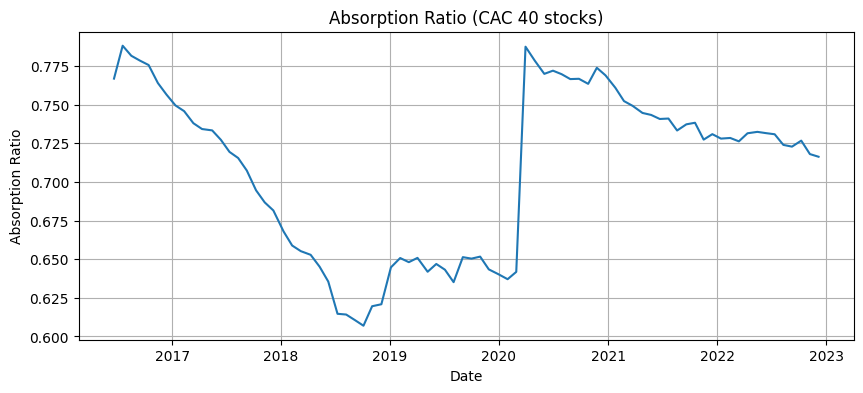

In [13]:
plt.figure(figsize=(10, 4))
plt.plot(ar_series.index, ar_series.values)
plt.xlabel("Date")
plt.ylabel("Absorption Ratio")
plt.title("Absorption Ratio (CAC 40 stocks)")
plt.grid(True)
plt.show()

**Interpretation of Results**

From the graph, I see that the Absorption Ratio slowly goes down from 2016 to around 2019. This means the CAC 40 stocks were less correlated, so the market looked more calm.

However, at the beginning of 2020, there is a very big jump. This is clearly the COVID-19 period, when almost all stocks moved together. After this shock, the AR stays quite high compared to the earlier years. So the market seems to have more common risk factors after 2020.

In general, the Absorption Ratio works as expected: it becomes high when the market is under stress and lower when conditions are normal.

In [14]:
# 5. AR “Delta” as a Systemic Risk Indicator
window_z = 12   # 12 AR observations  1 year if step_size 21 trading days

ar_mean = ar_series.rolling(window_z, min_periods=5).mean()
ar_std  = ar_series.rolling(window_z, min_periods=5).std()

ar_delta = (ar_series - ar_mean) / ar_std
ar_delta.name = "AR_delta"

ar_delta.tail()

window_z = 12   # 12 AR observations 1 year if step_size 21 trading days

ar_mean = ar_series.rolling(window_z, min_periods=5).mean()
ar_std  = ar_series.rolling(window_z, min_periods=5).std()

ar_delta = (ar_series - ar_mean) / ar_std
ar_delta.name = "AR_delta"

ar_delta.tail()

2022-08-11   -1.575751
2022-09-09   -1.568806
2022-10-10   -0.539809
2022-11-08   -2.217047
2022-12-07   -1.916157
Name: AR_delta, dtype: float64

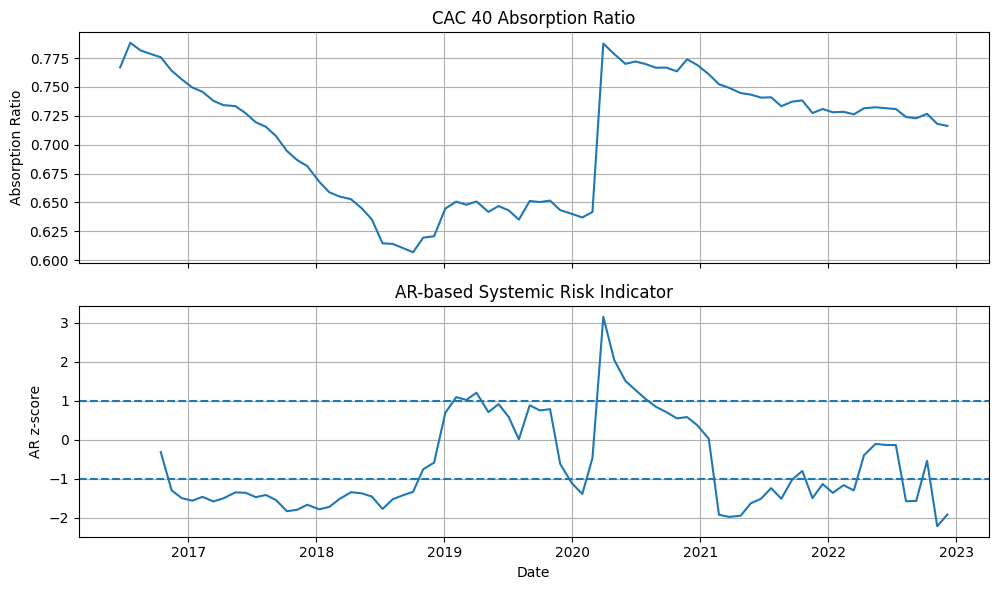

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax[0].plot(ar_series.index, ar_series.values)
ax[0].set_ylabel("Absorption Ratio")
ax[0].set_title("CAC 40 Absorption Ratio")

ax[1].plot(ar_delta.index, ar_delta.values)
ax[1].axhline(1.0, linestyle="--")
ax[1].axhline(-1.0, linestyle="--")
ax[1].set_ylabel("AR z-score")
ax[1].set_title("AR-based Systemic Risk Indicator")
ax[1].set_xlabel("Date")

for a in ax:
    a.grid(True)

plt.tight_layout()
plt.show()

**Interpretation of Results**

In the first plot, the Absorption Ratio goes down from 2016 to around 2019. This means the CAC 40 stocks were not very correlated, so the market looked more relaxed. But at the start of 2020, AR jumps a lot. This is the COVID period, when almost all stocks moved together. After that, AR stays higher than before, so the market seems to have more common risk.

In the second plot, the AR z-score shows similar information but in a clearer way. When the z-score is above 1, the market risk is high. When it is below –1, the market risk is low. I see a very big spike in early 2020, which again matches the COVID shock. Before 2020, the z-score is mostly negative, meaning lower risk. After 2020, it is more mixed but still sometimes high.

Overall, these two figures show that the PCA-based AR indicator reacts strongly during crisis periods and stays low when the market is calm.

In [16]:
# 6. Trading Strategy Based on AR (PCA)
def get_weight_from_ar(ar_delta_value: float):
    """
    Return [w_equity, w_cash] based on AR_delta threshold.
    """
    if ar_delta_value > 1.0:
        return np.array([0.0, 1.0])   # de-risk: all cash
    elif ar_delta_value < -1.0:
        return np.array([1.0, 0.0])   # risk-on: all equity
    else:
        return np.array([0.5, 0.5])   # neutral

# Align AR_delta to full daily index_returns
ar_daily = ar_delta.reindex(index_returns.index).ffill()

# Compute weights
w_equity = []
w_cash = []

for val in ar_daily.values:
    w = get_weight_from_ar(val)
    w_equity.append(w[0])
    w_cash.append(w[1])

wgts = pd.DataFrame({
    "EQ": w_equity,
    "CASH": w_cash
}, index=index_returns.index)

wgts.head()

def backtest_strategy(strat_wgts: pd.DataFrame,
                      asset_returns: pd.Series,
                      periods_per_year: int = 252):
    """
    Given EQ/CASH weights and CAC 40 daily returns:
    - Compute daily portfolio returns,
    - Return (annualized return, annualized vol, Sharpe).
    """
    df_ = strat_wgts.join(asset_returns.to_frame(name="EQ_ret"), how="inner")
    
    df_["port_ret"] = df_["EQ"] * df_["EQ_ret"]  # CASH assumed 0 return
    
    daily_ret = df_["port_ret"].dropna()
    
    ann_ret = daily_ret.mean() * periods_per_year
    ann_vol = daily_ret.std() * np.sqrt(periods_per_year)
    sharpe = ann_ret / ann_vol if ann_vol > 0 else np.nan
    
    return ann_ret, ann_vol, sharpe, daily_ret
    
# AR-driven strategy
ann_ret_ar, ann_vol_ar, sharpe_ar, daily_ret_ar = backtest_strategy(wgts, index_returns)

# Buy-and-hold 100% equity
wgts_100 = pd.DataFrame({"EQ": 1.0, "CASH": 0.0}, index=index_returns.index)
ann_ret_100, ann_vol_100, sharpe_100, daily_ret_100 = backtest_strategy(wgts_100, index_returns)

# 3) Static 50/50
wgts_50 = pd.DataFrame({"EQ": 0.5, "CASH": 0.5}, index=index_returns.index)
ann_ret_50, ann_vol_50, sharpe_50, daily_ret_50 = backtest_strategy(wgts_50, index_returns)

print("AR strategy:    ret = %.4f, vol = %.4f, Sharpe = %.2f" % (ann_ret_ar, ann_vol_ar, sharpe_ar))
print("100%% CAC 40:   ret = %.4f, vol = %.4f, Sharpe = %.2f" %(ann_ret_100, ann_vol_100, sharpe_100))
print("Static 50/50:   ret = %.4f, vol = %.4f, Sharpe = %.2f" % (ann_ret_50, ann_vol_50, sharpe_50))

AR strategy:    ret = 0.0210, vol = 0.1262, Sharpe = 0.17
100% CAC 40:   ret = 0.0651, vol = 0.1977, Sharpe = 0.33
Static 50/50:   ret = 0.0326, vol = 0.0989, Sharpe = 0.33


Cumulative Performance

100% CAC 40 achieves the highest long-run performance, especially during the strong post-2020 bull market.

Static 50/50 shows lower drawdowns but also lower total return.

AR strategy reduces losses in crisis periods (e.g., 2020 crash), but lags during extended rallies because it sometimes moves to cash.

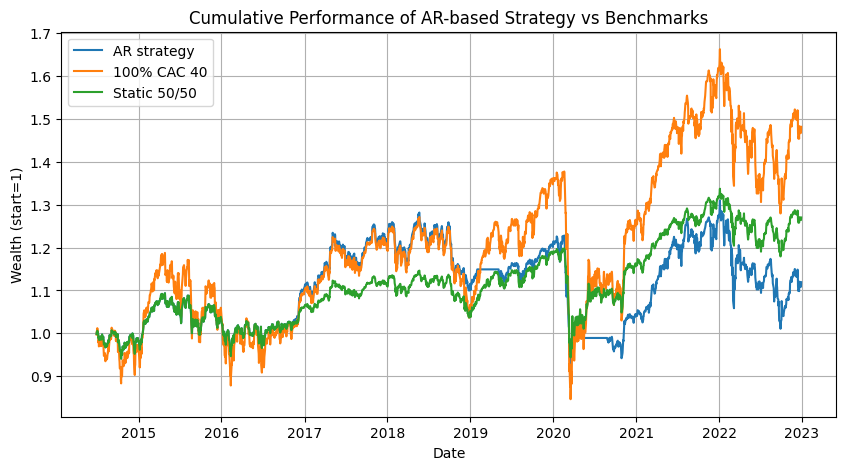

In [17]:
def cumulative_curve(daily_returns: pd.Series, label: str):
    cum = (1 + daily_returns).cumprod()
    plt.plot(cum.index, cum.values, label=label)

plt.figure(figsize=(10, 5))
cumulative_curve(daily_ret_ar, "AR strategy")
cumulative_curve(daily_ret_100, "100% CAC 40")
cumulative_curve(daily_ret_50, "Static 50/50")

plt.legend()
plt.grid(True)
plt.title("Cumulative Performance of AR-based Strategy vs Benchmarks")
plt.xlabel("Date")
plt.ylabel("Wealth (start=1)")
plt.show()

**Interpretation of Results**

From the plot, the 100% CAC 40 line grows the most in the long run, especially after 2020. This is because the market had a strong recovery and bull period, so staying fully in equities gives the highest return.

The Static 50/50 strategy is smoother. It does not go up as fast, but it also does not drop as much during bad times. It looks more stable.

The AR strategy is between the two. It avoids some losses in crisis periods (for example around the COVID crash), because it moves partly to cash when risk looks high. But in good years, like 2021, it does not grow as fast as 100% CAC 40, because sometimes it stays too cautious.

In general, the AR strategy protects a bit in bad times, but it also misses some upside. So its performance is okay, but not better than the simple benchmarks.

**Part 2: Going further: A bit of NLP on risk regulation**

In [18]:
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd

BASE_URL = "https://www.bis.org"
OVERVIEW_URL = "https://www.bis.org/bcbs/publ/comments/d402/overview.htm"

PDF_DIR = "data/d402_pdfs"
os.makedirs(PDF_DIR, exist_ok=True)

headers = {
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120 Safari/537.36"
}

resp = requests.get(OVERVIEW_URL, headers=headers)
resp.raise_for_status()
soup = BeautifulSoup(resp.text, "html.parser")

pdf_links = []

# Scan all of href in this websit
for a in soup.find_all("a"):
    href = a.get("href", "")
    text = a.get_text(strip=True)

    if not href:
        continue

    # Catch all pdfs
    if ".pdf" in href.lower():
        # revert http
        if href.startswith("http"):
            full_url = href
        elif href.startswith("/"):
            full_url = BASE_URL + href
        else:
            # in other situation
            full_url = BASE_URL + "/bcbs/publ/comments/d402/" + href

        pdf_links.append({
            "author": text,
            "href_raw": href,
            "url": full_url
        })

df_links = pd.DataFrame(pdf_links)
print("how many pdfs are found：", len(df_links))
print(df_links.head(5))

how many pdfs are found： 18
                                              author       href_raw  \
0             Association of Global Custodians (AGC)      aogca.pdf   
1  Association of Supervisors of Banks of the Ame...  aosobotaa.pdf   
2   Benoit, Hurlin and Perignon (French researchers)     bhapfr.pdf   
3                  British Bankers Association (BBA)       bbab.pdf   
4                 Canadian Bankers Association (CBA)       cbac.pdf   

                                                 url  
0  https://www.bis.org/bcbs/publ/comments/d402/ao...  
1  https://www.bis.org/bcbs/publ/comments/d402/ao...  
2  https://www.bis.org/bcbs/publ/comments/d402/bh...  
3  https://www.bis.org/bcbs/publ/comments/d402/bb...  
4  https://www.bis.org/bcbs/publ/comments/d402/cb...  


In [19]:
# 1.Download all pdfs

for _, row in df_links.iterrows():
    url = row["url"]
    fname = row["href_raw"].split("/")[-1]   # ex aogca.pdf
    path = os.path.join(PDF_DIR, fname)

    if os.path.exists(path):
        print("exist skip：", fname)
        continue

    print("download：", fname, " <- ", url)
    r = requests.get(url, headers=headers)
    r.raise_for_status()
    with open(path, "wb") as f:
        f.write(r.content)

exist skip： aogca.pdf
exist skip： aosobotaa.pdf
exist skip： bhapfr.pdf
exist skip： bbab.pdf
exist skip： cbac.pdf
exist skip： cba.pdf
exist skip： fandp.pdf
exist skip： fbf.pdf
exist skip： germanbankindus.pdf
exist skip： gfma.pdf
exist skip： hsbc.pdf
exist skip： iif.pdf
exist skip： jba.pdf
exist skip： santan.pdf
exist skip： statestreet.pdf
exist skip： tch.pdf
exist skip： ubs.pdf
exist skip： woccu.pdf


In [20]:
# 2.Extract contents form pdfs

from pypdf import PdfReader

def extract_text_pdf(path):
    reader = PdfReader(path)
    pages = []
    for p in reader.pages:
        txt = p.extract_text() or ""
        pages.append(txt)
    return "\n".join(pages)

records = []

for _, row in df_links.iterrows():
    fname = row["href_raw"].split("/")[-1]
    fpath = os.path.join(PDF_DIR, fname)

    try:
        text = extract_text_pdf(fpath)
    except:
        text = ""   

    records.append({
        "author": row["author"],
        "file": fname,
        "text": text
    })

df_text = pd.DataFrame(records)
df_text.head()

,author,file,text
0,Association of Global Custodians (AGC),aogca.pdf,\n\n
1,Association of Supervisors of Banks of the Ame...,aosobotaa.pdf,\nComments from ASBA to the Consultative Docu...
2,"Benoit, Hurlin and Perignon (French researchers)",bhapfr.pdf,1 \n \nProf. Sylvain Benoit \nUniversité Paris...
3,British Bankers Association (BBA),bbab.pdf,BBA response to BCBS - Revisions to assessment...
4,Canadian Bankers Association (CBA),cbac.pdf,"\n \n \nBox 348, Commerce Court West \n199 Ba..."


In [21]:
# 3.Clean the comments and calculate the words

import re

def clean_text(s):
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(r"\s+", " ", s)
    return s.strip()

df_text["text_clean"] = df_text["text"].apply(clean_text)
df_text["n_words"] = df_text["text_clean"].str.split().apply(len)
df_text

,author,file,text,text_clean,n_words
0,Association of Global Custodians (AGC),aogca.pdf,\n\n,,0
1,Association of Supervisors of Banks of the Ame...,aosobotaa.pdf,\nComments from ASBA to the Consultative Docu...,comments from asba to the consultative documen...,866
2,"Benoit, Hurlin and Perignon (French researchers)",bhapfr.pdf,1 \n \nProf. Sylvain Benoit \nUniversité Paris...,1 prof. sylvain benoit université paris‐dauphi...,840
3,British Bankers Association (BBA),bbab.pdf,BBA response to BCBS - Revisions to assessment...,bba response to bcbs - revisions to assessment...,9526
4,Canadian Bankers Association (CBA),cbac.pdf,"\n \n \nBox 348, Commerce Court West \n199 Ba...","box 348, commerce court west 199 bay street, 3...",760
5,China Banking Association (CBA),cba.pdf,"\n1 \n \n \n12F, Tower B, Bank of Communicati...","1 12f, tower b, bank of communications buildin...",1581
6,Fit and Proper LLC,fandp.pdf,"\nF&P, USA \n8750 NW 36 Street, Suite 425,...","f&p, usa 8750 nw 36 street, suite 425, miami, ...",1212
7,French Banking Federation (FBF),fbf.pdf,\n1 \n \n \n \n2017.06.30 \n \nFRENCH BANKING...,1 2017.06.30 french banking federation respons...,3209
8,German Banking Industry Committee,germanbankindus.pdf,\n \n \n \nCoordinator: \nNational Associatio...,coordinator: national association of german co...,791
9,Global Financial Markets Association (GFMA),gfma.pdf,\n \n \n \n \nLondon | Hong Kong | New York |...,london | hong kong | new york | www.gfma.org j...,4934


Two comments (AGC and HSBC) are scanned PDFs, so they are not included in the sentiment analysis.

In [22]:
# 4. Emotional analysis

# Positive words
POS_WORDS = [
    "good", "support", "supportive", "welcome", "agree", "broadly support",
    "endorse", "appropriate", "improve", "enhance", "balanced",
    "reasonable", "clarify", "helpful"
]

# Negative words
NEG_WORDS = [
    "bad", "concern", "concerns", "oppose", "opposition", "disagree",
    "negative", "harmful", "burden", "burdensome", "unduly conservative",
    "problematic", "difficulty", "uncertainty", "complex", "costly",
    "adverse", "unintended", "disproportionate"
]

# Calculate the score of emotion
def sentiment_score(text):
    t = text.lower()
    pos = sum(t.count(w) for w in POS_WORDS)
    neg = sum(t.count(w) for w in NEG_WORDS)
    total = pos + neg
    if total == 0:
        score = 0
    else:
        score = (pos - neg) / total
    return pos, neg, score

df_text[["pos", "neg", "sentiment"]] = df_text["text_clean"].apply(
    lambda x: pd.Series(sentiment_score(x))
)

# Label the emotion
def label(score):
    if score > 0.1: return "positive"
    if score < -0.1: return "negative"
    return "neutral"

df_text["sentiment_label"] = df_text["sentiment"].apply(label)
df_text[["author","sentiment_label","sentiment"]]

,author,sentiment_label,sentiment
0,Association of Global Custodians (AGC),neutral,0.000000
1,Association of Supervisors of Banks of the Ame...,positive,1.000000
2,"Benoit, Hurlin and Perignon (French researchers)",neutral,0.000000
3,British Bankers Association (BBA),neutral,0.097561
4,Canadian Bankers Association (CBA),positive,0.692308
5,China Banking Association (CBA),positive,0.142857
6,Fit and Proper LLC,positive,0.500000
7,French Banking Federation (FBF),positive,0.428571
8,German Banking Industry Committee,negative,-0.200000
9,Global Financial Markets Association (GFMA),positive,0.150000


**Interpretation of Results**

Most comments are positive or neutral. This suggests that many organisations generally accept the BIS proposal and do not strongly oppose it. Some institutions, such as ASBA and Santander, are clearly positive and express strong support.

A few organisations show negative sentiment, for example the German Banking Industry Committee and UBS. These comments contain more concerns and criticism, meaning that some parts of the proposal are seen as problematic for them.

Two comments (AGC and HSBC) are scanned PDFs, so their text cannot be extracted and they are not included in the sentiment analysis. Even without these two documents, the overall picture is clear.

Overall, the consultation feedback is mostly supportive, but there are still some concerns on specific issues raised by a small number of institutions.

In [23]:
# 5. Analyse intensity and tone

INTENSITY_WORDS = [
    "strongly", "significantly", "materially", "fundamental",
    "critical", "deeply", "highly", "urge", "serious"
]

def intensity(text, n_words):
    t = text.lower()
    count = sum(t.count(w) for w in INTENSITY_WORDS)
    return (count / max(n_words,1)) * 1000   # every 100 words

df_text["intensity"] = df_text.apply(
    lambda r: intensity(r["text_clean"], r["n_words"]), axis=1
)

In [24]:
# 6. Topic modeling

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

texts = df_text["text_clean"].tolist()

vectorizer = TfidfVectorizer(stop_words="english", max_features=2000)
X = vectorizer.fit_transform(texts)

lda = LatentDirichletAllocation(n_components=4, random_state=66)
topics = lda.fit_transform(X)

for i in range(4):
    df_text[f"topic_{i}"] = topics[:,i]

# look through the key words
def show_topics(model, feature_names, topn=10):
    for i, topic in enumerate(model.components_):
        top = topic.argsort()[-topn:]
        words = [feature_names[j] for j in top]
        print(f"Topic {i}: {words}")

show_topics(lda, vectorizer.get_feature_names_out())

Topic 0: ['12', 'total', 'life', 'bank', 'unions', 'investments', 'days', '60', 'irish', 'months']
Topic 1: ['committee', 'insurance', 'banking', 'methodology', 'risk', 'sib', 'assessment', 'indicator', 'framework', 'banks']
Topic 2: ['000', 'total', '12', 'managed', 'investments', 'banco', '289', 'life', 'estudios', 'santander']
Topic 3: ['000', 'total', '12', 'managed', 'investments', 'banco', '289', 'life', 'estudios', 'santander']


In [25]:
# 7. Comment Distribution Index

import numpy as np

def distribution_index(df):
    w = df["n_words"].values
    total = w.sum()
    s = w / total
    hhi = np.sum(s*s)
    N = len(w)
    if N <= 1:
        return 0
    index = (1/hhi - 1)/(N - 1)
    return index

CDI = distribution_index(df_text)
CDI

np.float64(0.45372209029520577)

The Comment Distribution Index is around 0.45.This number is between 0 and 1.
If the value is close to 1, it means comments are very evenly shared across all authors.
If it is close to 0, it means only a few authors dominate the comments.

So 0.45 means the distribution is in the middle.It is not very concentrated, but also not very equal. Some organisations write longer comments, but many others also participate.

**Comparison of two BIS documents**

In [26]:
# 1. Download the two BIS documents (2017 consultative vs 2018 final)

import os
import requests
from pypdf import PdfReader

DOC_DIR = "data/bis_docs"
os.makedirs(DOC_DIR, exist_ok=True)

urls = {
    "consult_2017": "https://www.bis.org/bcbs/publ/d402.pdf",
    "final_2018": "https://www.bis.org/bcbs/publ/d445.pdf"
}

def download_pdf(url, filename):
    """Download a PDF file if it does not exist."""
    path = os.path.join(DOC_DIR, filename)
    if not os.path.exists(path):
        print("Downloading:", filename)
        response = requests.get(url)
        response.raise_for_status()
        with open(path, "wb") as f:
            f.write(response.content)
    else:
        print("File already exists:", filename)
    return path

path_2017 = download_pdf(urls["consult_2017"], "d402_2017.pdf")
path_2018 = download_pdf(urls["final_2018"], "d445_2018.pdf")

# 2. extract contents from the pdfs and clean them

def extract_text_from_pdf(path):
    """Extract text from all pages of a PDF file."""
    reader = PdfReader(path)
    text = ""
    for page in reader.pages:
        text += page.extract_text() or ""
    return text

text_2017_raw = extract_text_from_pdf(path_2017)
text_2018_raw = extract_text_from_pdf(path_2018)

import re

def clean_text(text):
    """Lowercase and remove excessive whitespace."""
    text = text.lower()
    text = re.sub(r"\s+", " ", text)
    return text.strip()

text_2017 = clean_text(text_2017_raw)
text_2018 = clean_text(text_2018_raw)

# 3. Compute textual similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
X = vectorizer.fit_transform([text_2017, text_2018])

similarity_score = cosine_similarity(X[0], X[1])[0][0]
print("Cosine similarity between 2017 and 2018 documents:", similarity_score)

# 4. Word frequency comparison
from collections import Counter

def word_frequency(text, min_length=4):
    """Return word counts for words of at least min_length letters."""
    words = re.findall(r"[a-zA-Z]{4,}", text)
    return Counter(words)

freq_2017 = word_frequency(text_2017)
freq_2018 = word_frequency(text_2018)

all_words = set(freq_2017.keys()) | set(freq_2018.keys())

rows = []
for word in all_words:
    rows.append({
        "word": word,
        "freq_2017": freq_2017.get(word, 0),
        "freq_2018": freq_2018.get(word, 0),
        "diff": freq_2018.get(word, 0) - freq_2017.get(word, 0)
    })

import pandas as pd
df_words = pd.DataFrame(rows)

# 6. Identify largest increases / decreases

# Words with the largest increases in 2018
df_increase = df_words[df_words["diff"] > 0].sort_values("diff", ascending=False).head(20)

# Words with the largest decreases in 2018
df_decrease = df_words[df_words["diff"] < 0].sort_values("diff").head(20)

print("Top words increasing in 2018:")
print(df_increase)

print("\nTop words decreasing in 2018:")
print(df_decrease)

# 7. List words that appear in one version but not the other
df_increase = df_words[df_words["diff"] > 0].sort_values("diff", ascending=False).head(20)

# Words with the largest decreases in 2018
unique_to_2017 = [w for w in all_words if freq_2018.get(w,0)==0]
unique_to_2018 = [w for w in all_words if freq_2017.get(w,0)==0]

print("Words only in 2017:", unique_to_2017[:20])
print("Words only in 2018:", unique_to_2018[:20])

File already exists: d402_2017.pdf
File already exists: d445_2018.pdf
Cosine similarity between 2017 and 2018 documents: 0.6964950098792058
Top words increasing in 2018:
              word  freq_2017  freq_2018  diff
1376   requirement         23         88    65
807           sibs          9         71    62
623           that         62        121    59
199        capital          8         53    45
158       approach          5         47    42
62          higher         16         58    42
417     absorbency          8         48    40
467           loss         13         51    38
959         impact         28         59    31
96       financial         24         53    29
1633          bank         35         60    25
182       judgment          0         24    24
669          basel          9         32    23
1163          with         36         59    23
187        failure          6         28    22
1625         based         19         40    21
659      magnitude          4  

**Interpretation of Results**

When I compare the 2017 and 2018 BIS documents, I see that many words change a lot.
Some words become much more frequent in 2018.
For example, “requirement”, “capital”, “higher”, “approach”, “impact”, “financial”, and “bank”.
These words all increase a lot.
To me, this looks like the 2018 version focuses more on the final rules, the capital numbers, and the more technical parts of the framework.

Some other words become much less frequent in 2018.
For example, “gsib”, “changes”, “proposed”, “framework”, “assessment”, “trading”, “short”, “funding”, and “stwf”.
These words are mainly related to the consultation process and the parts that banks complained about.
So maybe BIS removed some details or reduced the importance of some indicators, like STWF.

There are also some words only in 2017 and some only in 2018.
This also shows the documents are not the same; the final version is more “official” and less about “proposals”.

Overall, the 2018 document looks more stable and rule-based, while the 2017 one looks more like a draft with many proposals and changes.
So I think BIS changed the document after reading the comments, making the final version clearer and more focused on the final requirements.